## Part 5 :Model Evaluation

### In this part, the models trained will be evaluated in 3 main metrics:

1. The loss and accuracy - Compare the metrics used in the 4 sample models and decide which model to use for the final model and what is the optimum number of `epochs` to train the model.

2. Mean Average Precision (mAP) - Evaluate the models using the mAP metric with different thresholds. From here , the IOU threshold and prediction threshold will be decided.
                                  At the same time, the training efficiency will be taken into consideration

3. The confusion matrix - Evaluate the final model's performance in terms of the confusion matrix for different classes

At the end, the demonstration of the result from the best model will be shown.

---

### 1. Loss and Accuracy



In [1]:
from tensorboard.backend.event_processing import event_accumulator # the tool needed to extract the loss metrics and accuracy from training in Detectron2
import pandas as pd
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
import seaborn as sns

import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import BoxMode,pairwise_iou,Boxes

In [2]:
# Visualisation of the training metrics
%reload_ext tensorboard
%tensorboard --logdir 'C:/Users/pkfei/OneDrive/Desktop/Git/RoadObjectDetection/assets/test'

Reusing TensorBoard on port 6006 (pid 10684), started 4 days, 23:49:39 ago. (Use '!kill 10684' to kill it.)

Those are metrics printed out at every iteration of the training loop. 

 - total_loss: This is a weighted sum of the following individual losses calculated during the iteration. By default, the weights are all one.

 - loss_cls: Classification loss in the ROI head. Measures the loss for box classification, i.e., how good the model is at labelling a predicted box with the correct class.

 - loss_box_reg: Localisation loss in the ROI head. Measures the loss for box localisation (predicted location vs true location).

 - loss_rpn_cls: Classification loss in the Region Proposal Network. Measures the "objectness" loss, i.e., how good the RPN is at labelling the anchor boxes as foreground or background.

 - loss_rpn_loc: Localisation loss in the Region Proposal Network. Measures the loss for localisation of the predicted regions in the RPN.

 - loss_mask: Mask loss in the Mask head. Measures how "correct" the predicted binary masks are.

In [3]:
event_path = 'C:/Users/pkfei/OneDrive/Desktop/Git/RoadObjectDetection/assets' # path to the training metrics

In [4]:
# Function to extract the loss metrics and accuracy from training event file 

def get_event(event_file):
      event_acc = event_accumulator.EventAccumulator(event_file,size_guidance=
      { 
      event_accumulator.COMPRESSED_HISTOGRAMS: 500,
      event_accumulator.IMAGES: 4,
      event_accumulator.AUDIO: 4,
      event_accumulator.SCALARS: 0,
      event_accumulator.HISTOGRAMS: 1,
      })
      event_acc.Reload()
      return event_acc

In [5]:
# Put the result in a dataframe 

'''
The 4 models trained are:
1. Freeze 1 layer the backbone
2. Freeze 2 layers the backbone
3. Freeze 3 layers the backbone
4. Freeze 4 layers the backbone 
'''

loss_dic = {}

for file in os.listdir(event_path): # loop through the training metrics
    if ('tfevents') in file:
        event_file = os.path.join(event_path, file)
        ea = get_event(event_file)
        print(file)
        loss_dic[file] = {'total_loss':ea.Scalars('total_loss')[:-1], 
                          'fast_rcnn_cls_accuracy':ea.Scalars('fast_rcnn/cls_accuracy')[:-1],
                          'mask_rcnn_accuracy':ea.Scalars('mask_rcnn/accuracy')[:-1]}
    
df = pd.DataFrame(loss_dic)    

1events.out.tfevents.1665441966.fc6fa80a112d.118.0
2events.out.tfevents.1665289604.1b39629b5480.75.0
3events.out.tfevents.1665303334.1b39629b5480.9347.0
4events.out.tfevents.1665324499.936fc5a6f3f0.76.0


In [6]:
df.columns = ['train_4layers','train_3layers','train_2layers','train_1layers']
df.head()

train_4layers  \
total_loss              [(1665442056.0981827, 19, 4.065192222595215), ...   
fast_rcnn_cls_accuracy  [(1665442056.09672, 19, 0.02099609375), (16654...   
mask_rcnn_accuracy      [(1665442056.0967722, 19, 0.6314368844032288),...   

                                                            train_3layers  \
total_loss              [(1665289620.8160212, 19, 3.6017725467681885),...   
fast_rcnn_cls_accuracy  [(1665289620.815233, 19, 0.3310546875), (16652...   
mask_rcnn_accuracy      [(1665289620.8152862, 19, 0.4226274788379669),...   

                                                            train_2layers  \
total_loss              [(1665303345.868283, 19, 3.80696964263916), (1...   
fast_rcnn_cls_accuracy  [(1665303345.8675754, 19, 0.01220703125), (166...   
mask_rcnn_accuracy      [(1665303345.8676295, 19, 0.43710049986839294)...   

                                                            train_1layers  
total_loss              [(1665324558.9314797, 19, 3.8392951488494873),...  
fast_rcnn_cls_accuracy  [(1665324558.9306731, 19, 0.02734375), (166532...  
mask_rcnn_accuracy      [(1665324558.9307287, 19, 0.5354871153831482),...

In [7]:
# Plot the loss metrics and accuracy for the 4 models trained

colours = ['blue','yellow','green','orange']
title = ['Total Loss','Fast RCNN Classification Accuracy','Mask RCNN Accuracy']

def plot_loss(df,colours,title):
    fig,ax = plt.subplots(nrows=3,figsize=(10,15))
    plt.style.use('seaborn')

    for i in range(len(df.columns)):
        df_plot = pd.DataFrame(df[df.columns[i]]['total_loss'])
        x = df_plot['step']/2000             # 2000 iterations per epoch, to plot the number of epochs as x axis
        if df.columns[i] == 'train_4layers':
          alpha = 1                          # alpha = 1 for the 4 layers model to make it more visible

        else:
          alpha = 0.3
      
        ax[0].plot(x,pd.DataFrame(df[df.columns[i]]['total_loss'])['value'],color=colours[i],alpha=alpha) # plot the total loss
        ax[0].set_title(title[0])
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_ylim(0.2,1.5)
        ax[0].legend(['train 4 Layers','train 3 Layers','train 2 Layers','train 1 Layers'])
        ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)

        ax[1].plot(x,pd.DataFrame(df[df.columns[i]]['fast_rcnn_cls_accuracy'])['value'],color=colours[i],alpha=alpha) # plot the fast rcnn classification accuracy
        ax[1].set_title(title[1])
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_ylim(0.8,1)
        ax[1].legend(['train 4 Layers','train 3 Layers','train 2 Layers','train 1 Layers'])
        ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)
        
        ax[2].plot(x,pd.DataFrame(df[df.columns[i]]['mask_rcnn_accuracy'])['value'],color=colours[i],alpha=alpha)   # plot the mask rcnn accuracy
        ax[2].set_title(title[2])
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Accuracy')
        ax[2].set_ylim(0.8,1)
        ax[2].legend(['train 4 Layers','train 3 Layers','train 2 Layers','train 1 Layers'])
        ax[2].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)
    return ax


C:\Users\pkfei\AppData\Local\Temp\ipykernel_42864\225844711.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


array([<AxesSubplot: title={'center': 'Total Loss'}, xlabel='Epochs', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'Fast RCNN Classification Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
       <AxesSubplot: title={'center': 'Mask RCNN Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
      dtype=object)

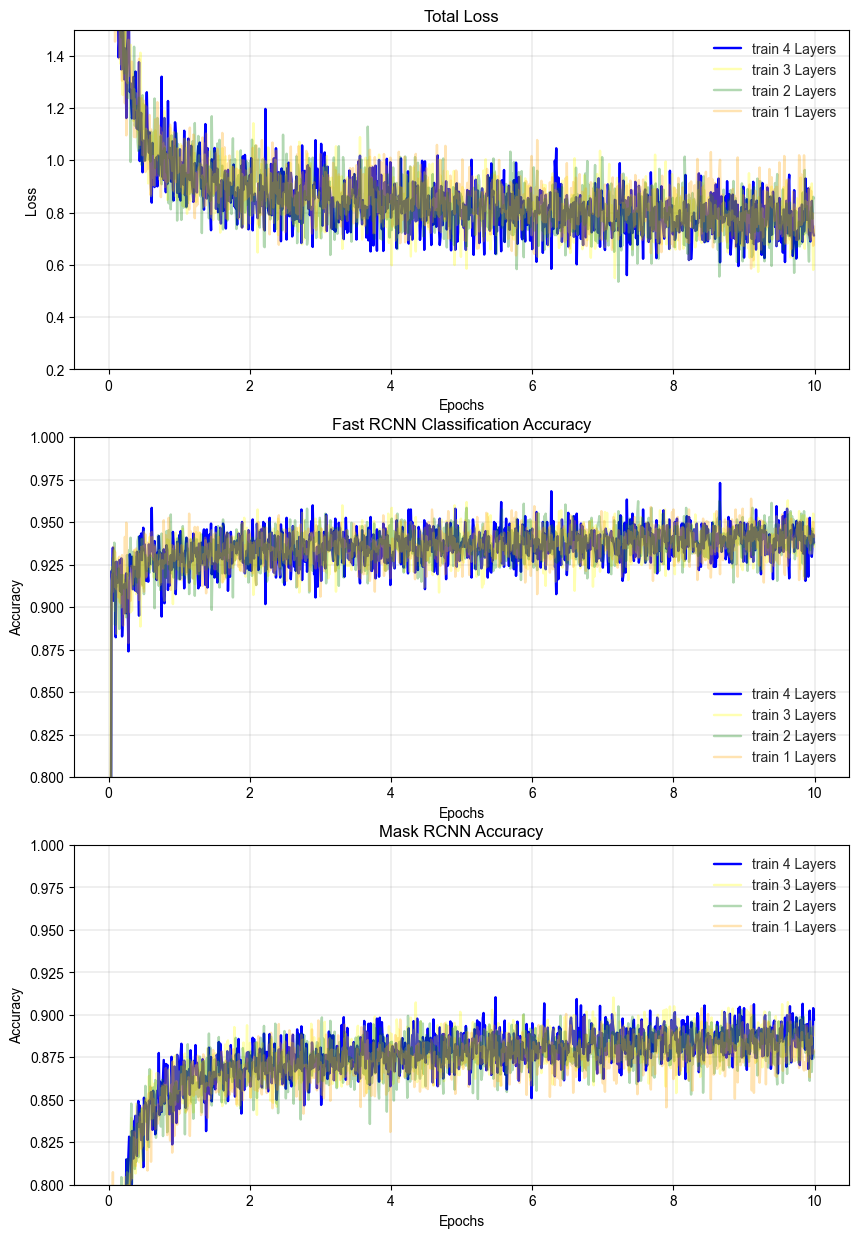

In [8]:
plot_loss(df,colours,title)

From the results, we can see that the loss is decreasing and the accuracy is increasing with number of iteration. The accuracy is calculated by the number of correct predictions divided by the total number of predictions.
The more epochs we train, the better the model will be. However, the training time will increase exponentially. Therefore, we need to find the optimum number of epochs to train the model.

In addition, although the model trained with 4 layers in backbone structure seems to **slightly** outperform the other models, the training time is much longer. Therefore, we will not decide which model to use based on the loss and accuracy. But with the mAP metric, we will be able to decide which model to use.

One important key point is that with given enough resources (e.g. GPU and Project time), the model can be trained with more epochs to achieve better performance. However, in this project, we will only train the model with 10 epochs.

---

### 2. Mean Average Precision (mAP) 

The metrics are collected from `Part3 - Model Training.ipynb`. The mAP of bounding box will be used for comparison to decide which model to use. The mAP of mask will be used to evaluate the final model.


In [9]:
# The mAP score for the 4 models trained for multiple IOU thresholds

data = [[26.3398,39.9772,28.7822,17.6219,32.4148,43.9930,'2:48:41'],[28.0221,42.3496,30.6473,19.3370,34.8835,43.8593,'3:10:46'],
        [29.2888,45.9501,31.4864,21.4624,35.3020,44.9874,'3:32:42'],[29.8829,45.5044,32.6255,22.4120,36.1661,44.0619,'3:54:51']]
column = ['mAP','mAP_50','mAP_75','mAP_s','mAP_m','mAP_l','training time']
index = ['train_1layers','train_2layers','train_3layers','train_4layers']

evaluation = pd.DataFrame(data=data,index=index,columns=column)

In [10]:
evaluation.head()

mAP   mAP_50   mAP_75    mAP_s    mAP_m    mAP_l  \
train_1layers  26.3398  39.9772  28.7822  17.6219  32.4148  43.9930   
train_2layers  28.0221  42.3496  30.6473  19.3370  34.8835  43.8593   
train_3layers  29.2888  45.9501  31.4864  21.4624  35.3020  44.9874   
train_4layers  29.8829  45.5044  32.6255  22.4120  36.1661  44.0619   

              training time  
train_1layers       2:48:41  
train_2layers       3:10:46  
train_3layers       3:32:42  
train_4layers       3:54:51

mAP is the average mean average precision of all classes for the IOU threshold from 0.5 to 0.95 with a step of 0.05. The prediction threshold is set to 0.5.
The mAP for different IOU threshold are plot together in the next cell to show the performance of the model.

[None]

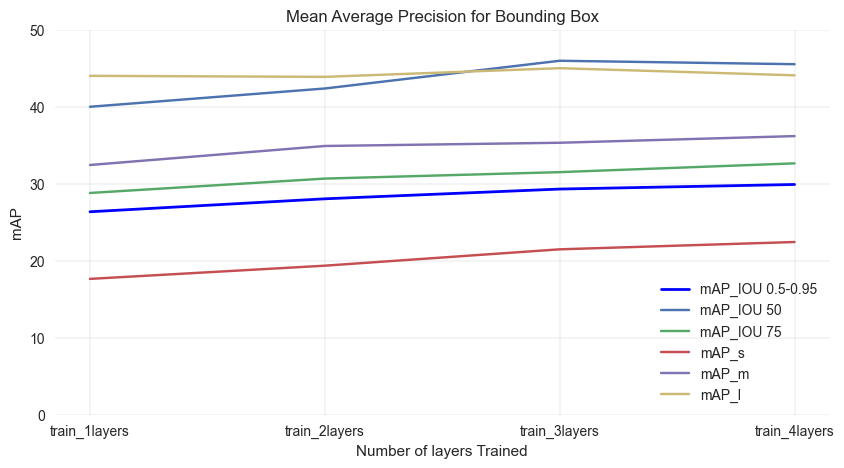

In [11]:
# Plot the mAP score for the 4 models trained for multiple IOU thresholds

fig,ax = plt.subplots(nrows=1,figsize=(10,5))

plt.plot(evaluation.index, evaluation['mAP'],color='blue',linewidth=2)
plt.plot(evaluation.index, evaluation['mAP_50'])
plt.plot(evaluation.index, evaluation['mAP_75'])
plt.plot(evaluation.index, evaluation['mAP_s'])
plt.plot(evaluation.index, evaluation['mAP_m'])
plt.plot(evaluation.index, evaluation['mAP_l'])

ax.set_title('Mean Average Precision for Bounding Box')
ax.set_xlabel('Number of layers Trained')
ax.set_ylabel('mAP')
ax.set_ylim(0,50)
plt.legend(['mAP_IOU 0.5-0.95','mAP_IOU 50','mAP_IOU 75','mAP_s','mAP_m','mAP_l'])
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set(facecolor = "white")

The results shows the more layers are trained, the better the model performs. So, ideally, the model trained with 4 layers is the best model, without considering the training time.

From here, the mAP with IOU threshold with 0.75 will be choosen for further evaluation. The reason is that the mAP with IOU threshold with 0.75 is close to average mAP and can represent the general performance of the model. In addition, the mAP with IOU threshold with 0.75 is the most common threshold used in the industry. The model also has the best performance in detecting the large objects.

In [12]:
# Put the training time for each model trained in the plot

evaluation['improvement'] = ((evaluation['mAP'] - evaluation['mAP'][0])/evaluation['mAP'][0]*100)+5
evaluation['trainingtime'] = evaluation['training time'].str.split(':').apply(lambda x: int(x[0])*3600 + int(x[1])*60 + int(x[2]))
evaluation['timeincrease'] = ((evaluation['trainingtime'] - evaluation['trainingtime'][0])/evaluation['trainingtime'][0]*100)+5

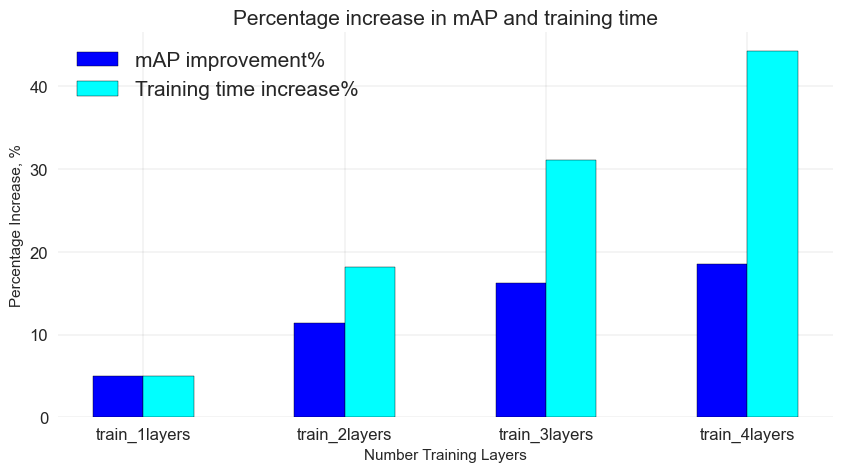

In [13]:
fig,ax = plt.subplots(nrows=1,figsize=(10,5))
x = np.arange(len(evaluation.index))
width=0.25
plt.bar(x, evaluation['improvement'],color='blue',width=width, edgecolor='black',label='mAP improvement%')
plt.bar(x+width, evaluation['timeincrease'],color='cyan',width=width, edgecolor='black',label='Training time increase%')

ax.set_title('Percentage increase in mAP and training time',fontsize=15)
ax.set_xlabel('Number Training Layers')
ax.set_ylabel('Percentage Increase, %')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set(facecolor = "white")
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(x+width/2,evaluation.index)
plt.legend(fontsize=15)

#ax2 = ax.twinx()
#ax2.plot(x, evaluation['training time'],color='indigo',linewidth=2,marker='o',label='Training time (hour)')
#ax2.set_ylabel('Training time (hour)')
#ax2.tick_params(axis='both', which='major', labelsize=10)
#ax2.set_ylim(0,8)

After taking training time into consideration, the model perfoemance does not improve significantly with more layers compare to the increase in training time. 
Therefore, the model trained with 1 layers should be the best model to use in this project (with limited resources). However, it is still the stake holder's judgement call to decide on the mAP requirement.

For this project, since the model with 4 layers is already trained, we will use the model with 4 layers as the final model.

| Event | Decision |
| --- | --- |
| Final Model | Mask RCNN FPN Trained with 4 backbone layers |
| IOU Threshold | 0.75 |
| Prediction Threshold | 0.7 |


---

### 3. Confusion Matrix

Before drawing conclusion in confusion matrix with the choosen model, we will first evaluate the preformance of each classes in the model with the mAP metric.
There are 8 classess :
1. Drivable Surface
2. Car
3. Pedestrian
4. Barrier
5. Trafficcone
6. Truck
7. Motorcycle
8. Construction Worker

In [14]:
# Result gotton from Part2: Model Training

AP_bbox = [55.894,49.407,25.169,24.296,29.485,25.866,24.114,4.833]
AP_mask = [25.913,46.634,20.615,26.417,29.579,25.335,20.266,4.773]
columns = ['AP_bbox','AP_mask']
index = ['drivable surface','car','pedestrian','barrier','trafficcone','truck','motorcycle','construction_worker']
df_class = pd.DataFrame(data=[AP_bbox,AP_mask],index=columns,columns=index).T

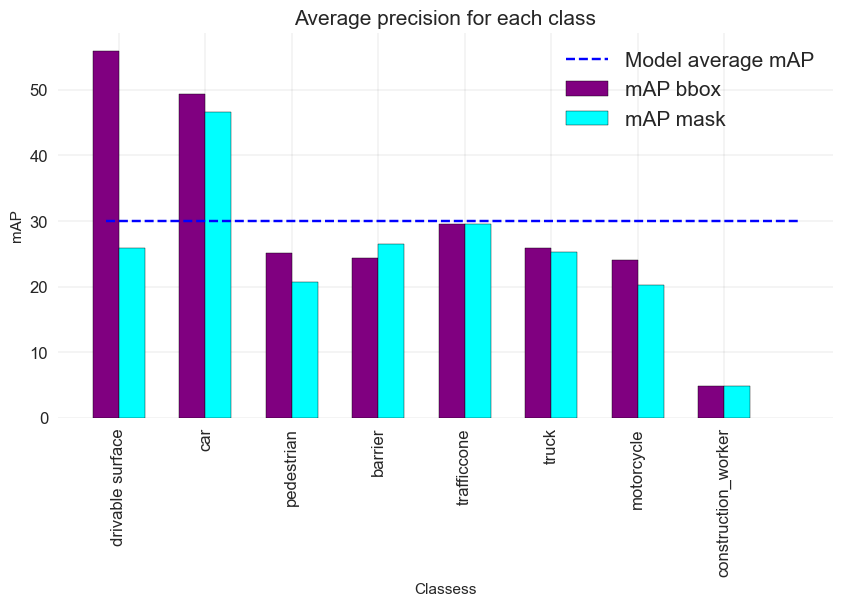

In [15]:
# Visualize the result 

fig,ax = plt.subplots(nrows=1,figsize=(10,5))
x = np.arange(len(df_class.index))
width=0.3
plt.bar(x, df_class['AP_bbox'],color='purple',width=width, edgecolor='black',label='mAP bbox')
plt.bar(x+width, df_class['AP_mask'],color='cyan',width=width, edgecolor='black',label='mAP mask')

ax.set_title('Average precision for each class',fontsize=15)
ax.set_xlabel('Classess')
ax.set_ylabel('mAP')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set(facecolor = "white")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.hlines(y=30,xmin = 0, xmax = 8, linestyles='dashed',color='blue',label='Model average mAP')
plt.xticks(x+width/2,df_class.index,rotation=90)
plt.legend(fontsize=15)

The result shows the class  mAP performance has close relation with the percentage of the class in the dataset. The class with higher percentage in the dataset has higher mAP. This is the problem caused by imbalance dataset.

However, the pedestrian and construction worker classes are exceptional low in mAP. This might due to the fact that the pedestrian and construction worker image pixels are very close, this model does not do a good job in distinguishing them. Another possible reason is the wrong annotation of the pedestrian and construction worker classes.

#### Plot the confusion matrix

Due to the limitation of local machine storage and time, the confusion matrix code is run on Google Colab (`Part5.1 Get_Confusion_Matrix.ipynb`). The result is saved in `confusion_matrix.csv` and loaded in the next cell.

In [16]:
with open('assets/confusionmatrix.csv', 'r') as f:
    reader = pd.read_csv(f)

In [17]:
reader.set_index('Unnamed: 0',inplace=True)
reader.index.name = None

In [18]:
reader

drivable surface    car  pedestrian  barrier  \
drivable surface               1344.0    1.0         0.0      0.0   
car                               0.0  930.0         0.0      0.0   
pedestrian                        0.0    0.0       579.0      0.0   
barrier                           0.0    0.0         0.0    310.0   
trafficcone                       0.0    0.0         0.0      0.0   
truck                             0.0   10.0         0.0      0.0   
motorcycle                        0.0    1.0         1.0      0.0   
construction worker               0.0    0.0        18.0      0.0   
NaN                             723.0  456.0       427.0    284.0   

                     trafficcone  truck  motorcycle  construction worker  \
drivable surface             5.0    0.0         0.0                  0.0   
car                          0.0    2.0         0.0                  0.0   
pedestrian                   0.0    0.0         0.0                  0.0   
barrier                      3.0    0.0         0.0                  0.0   
trafficcone                302.0    0.0         0.0                  0.0   
truck                        0.0   69.0         0.0                  0.0   
motorcycle                   0.0    0.0        56.0                  0.0   
construction worker          0.0    0.0         0.0                  6.0   
NaN                        205.0   37.0        51.0                 27.0   

                      null  
drivable surface     587.0  
car                  605.0  
pedestrian           925.0  
barrier              598.0  
trafficcone          412.0  
truck                110.0  
motorcycle            94.0  
construction worker  141.0  
NaN                    0.0

Text(0.5, 1.0, 'Confusion Matrix')

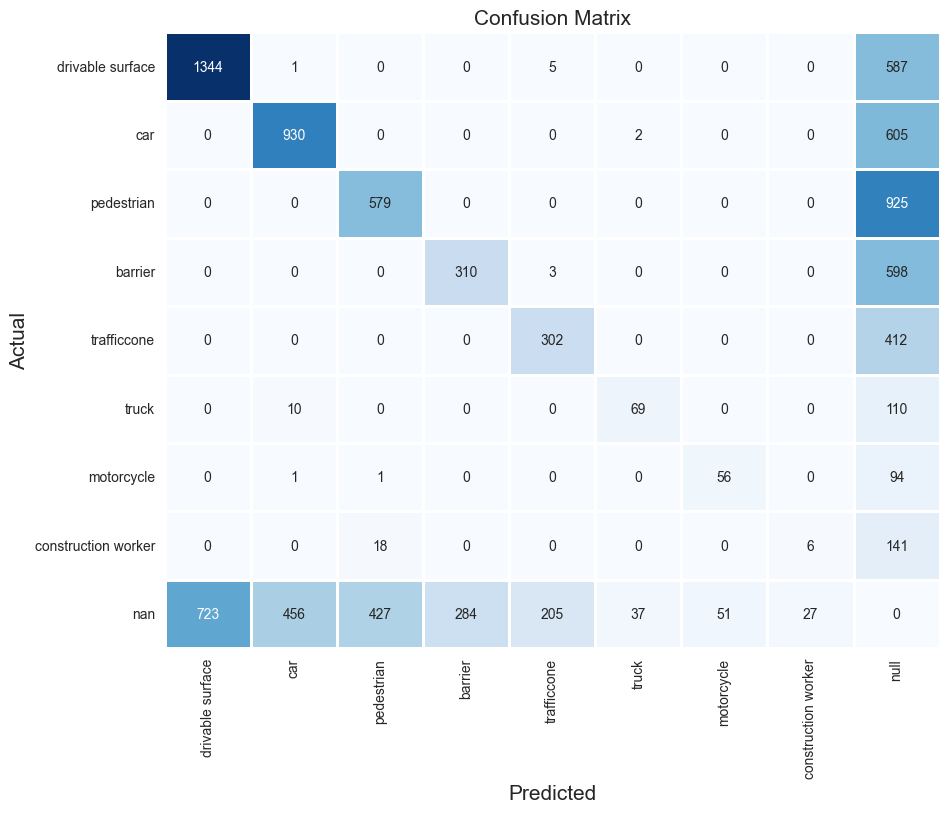

In [19]:
# Visualize the confusion matrix in heatmap

ax,fig = plt.subplots(figsize=(10,8))

sns.heatmap(reader, annot=True, fmt='g',cmap='Blues',linewidths=2,cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title('Confusion Matrix',fontsize=15)

The null rows and columns means that the model predict the class but the actual annotation does not label the object. 
This main reason might due to either the annotation file is wrong or the model is not good enough to predict the class.This also explain that why the mAP of the best model is not very high (0.45 mAP on large object). We will try to visualize the actual reason in the demo session. 

To further understand the model performance, we will plot the confusion matrix by ignoring the null rows and columns.

In [20]:
confusionmatrix = reader.drop(columns=["null"])[:-1] # drop the last row and column

Text(0.5, 1.0, 'Confusion Matrix')

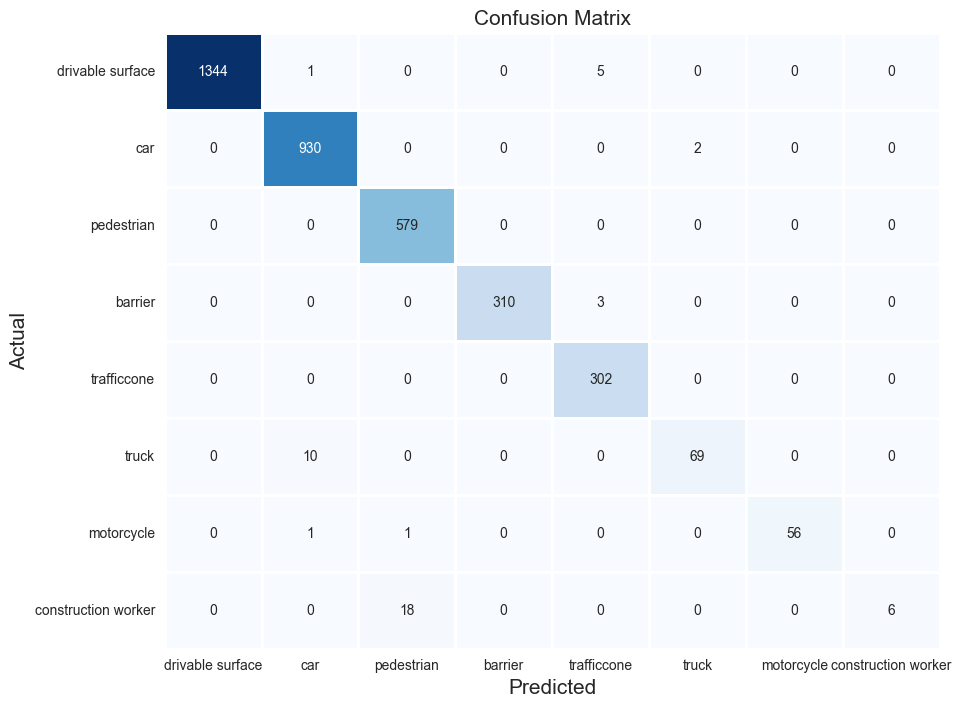

In [21]:
ax,fig = plt.subplots(figsize=(10,8))

sns.heatmap(confusionmatrix, annot=True, fmt='g',cmap='Blues',linewidths=2,cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual' , fontsize=15)
plt.title('Confusion Matrix',fontsize=15)

For the object that located correctly by the object, it does a good job in classifying the object. The true recall and precision of each category is very high (>0.9) except construction worker class. This might due to the fact that the model does not do a good job in distinguishing the pedestrian and construction worker classes. 

---

### 4. Compasrison of the predicted result with the ground truth 

```Setup the predictor model```

In [22]:
im_dir = 'C:/Users/pkfei/OneDrive/Desktop/Git/RoadObjectDetection/assets'

def get_dicts(img_dir):
    json_file = os.path.join(img_dir, "json_annotation.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns):
        record = {}
        
        filename = os.path.join(img_dir, v["file_name"])
        height = v["height"]
        width = v["width"]
        category_id = v["category_id"]
        mask = v["TrueMask"]
        bbox = v["bbox"]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        objs = []
        for i in range(len(category_id)):
            obj = {
                "bbox": bbox[i],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [mask[i]],
                "category_id": category_id[i],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("capstone_" + d, lambda d=d: get_dicts(im_dir + '/' + d))
    MetadataCatalog.get("capstone_" + d).set(thing_classes=["drivable surface","car","pedestrian","barrier","trafficcone","truck","motorcycle","construction worker"])
    MetadataCatalog.get("capstone_" + d).set(thing_colors=[[0, 0, 255],[255, 165, 0],[255, 0, 0],[0, 255, 0],[255, 255, 0],[255, 0, 255],[0, 255, 255],[255, 255, 255]])
capstone_metadata = MetadataCatalog.get("capstone_train")

class MyVisualizer(Visualizer):
    def _jitter(self, color):
        return color


In [23]:
# Model Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.MODEL.WEIGHTS = os.path.join(im_dir, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.75]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
cfg.MODEL.DEVICE = "cpu"  # use GPU if available
predictor = DefaultPredictor(cfg)

In [24]:
val_img = os.path.join(im_dir,'val') # path to the validation images
train_img = os.path.join(im_dir,'train') # path to the training images

In [25]:
# Function to visualize the labelled images 
def get_label_img(im_dir, filename):
    dataset_dicts = get_dicts(im_dir)
    file_name = os.path.join(im_dir,filename)
    for d in dataset_dicts:
       if d['file_name'] == file_name:
         img = cv2.imread(file_name)
         visualizer = Visualizer(img[:, :, ::-1], metadata=capstone_metadata, scale=1, instance_mode=ColorMode.SEGMENTATION)
         out = visualizer.draw_dataset_dict(d)
         plt.imshow(out.get_image())  
         plt.grid(False)
         plt.xticks([])
         plt.yticks([])
         plt.title('Labelled image',fontsize=15)

In [26]:
# Function to visualize the prediction result on validation images
def get_predicted_img (im_dir, filename):
    file_name = os.path.join(im_dir,filename)
    im = cv2.imread(file_name)
    outputs = predictor(im)  

    v = Visualizer(im[:, :, ::-1],
              metadata=capstone_metadata, 
              scale=1, 
              instance_mode=ColorMode.SEGMENTATION
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())  
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted image',fontsize=15)

### A. Invetigate the reason why construction worker class has low mAP 

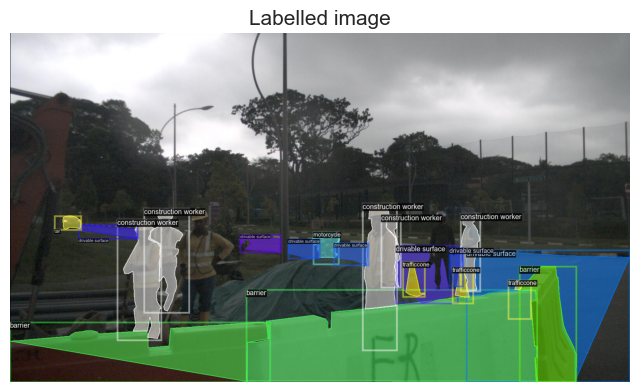

In [27]:
get_label_img(train_img,'n013-2018-07-30-11-58-27+0800__CAM_FRONT_LEFT__1532923529104825.jpg')

c:\Users\pkfei\anaconda3\envs\Capstone\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


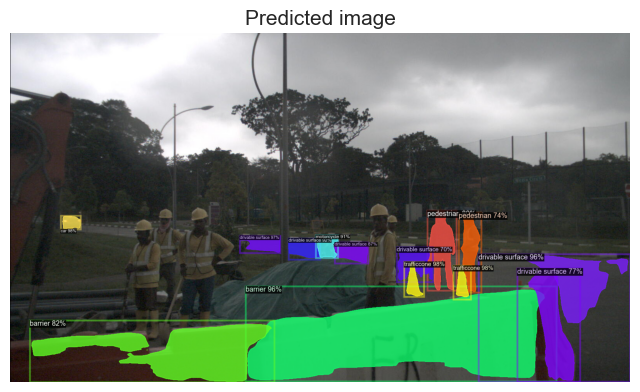

In [28]:
get_predicted_img(train_img,'n013-2018-07-30-11-58-27+0800__CAM_FRONT_LEFT__1532923529104825.jpg')

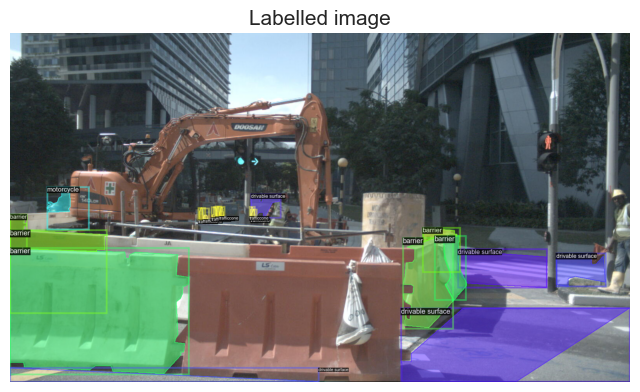

In [29]:
get_label_img(val_img,'n003-2018-07-12-15-40-35+0800__CAM_FRONT_LEFT__1531381452505224.jpg')

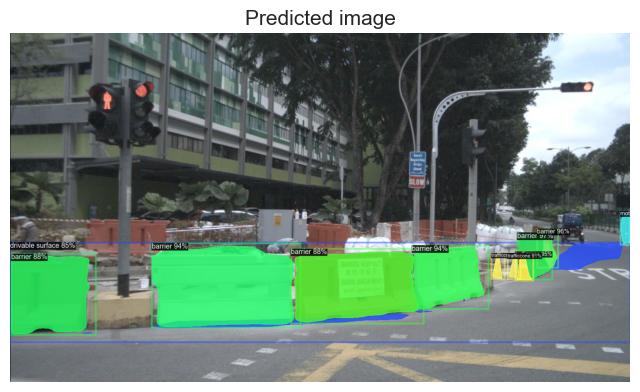

In [30]:
get_predicted_img(val_img,'n010-2018-07-06-11-01-46+0800__CAM_BACK_LEFT__1530846410947633.jpg')

There are alot of miss annotation in the original label file. The construction worker class is not mask out in the image. Therefore, the model does not predict the construction worker class accurately.

Another reason is as shown in the images above, the construction worker does not wear a uniform. The model does not do a good job in distinguishing the construction worker and pedestrian classes. The model also failed to detect the object that is too small that even human eye cannot see it.


### B. Prediction result in raining weather

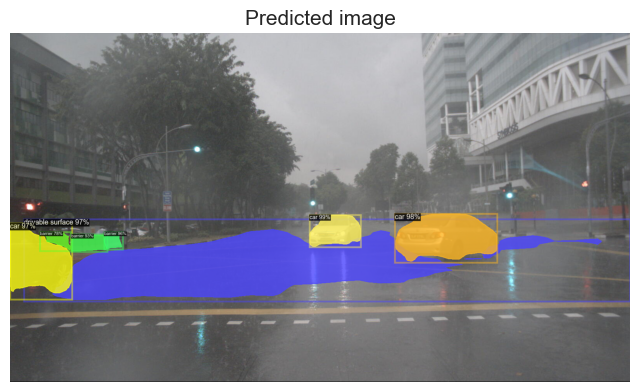

In [31]:
get_predicted_img(val_img,'n004-2018-02-23-15-05-17+0800__CAM_FRONT__1519369991907473.jpg')

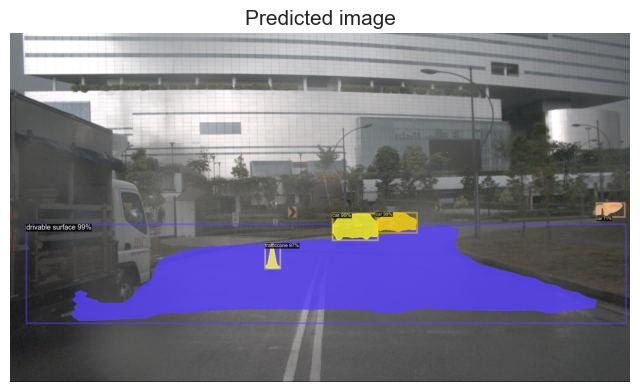

In [32]:
get_predicted_img(train_img,'n004-2018-02-23-15-05-17+0800__CAM_FRONT__1519369827068367.jpg')

The model does a good job in predicting the object in the raining weather. This is because the raining weather is incuded in the dataset.

### B. Prediction result in night

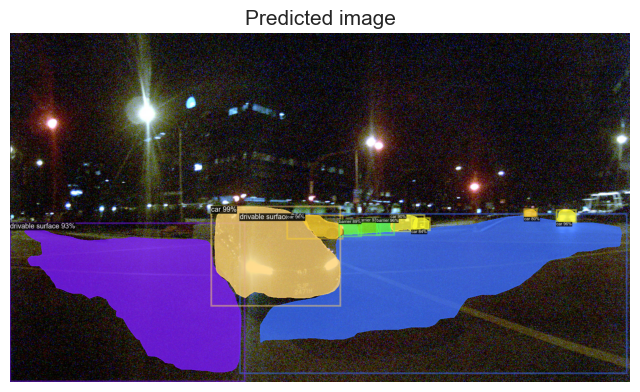

In [33]:
get_predicted_img(train_img,'n005-2018-06-14-20-11-03+0800__CAM_BACK__1528980200037591.jpg')

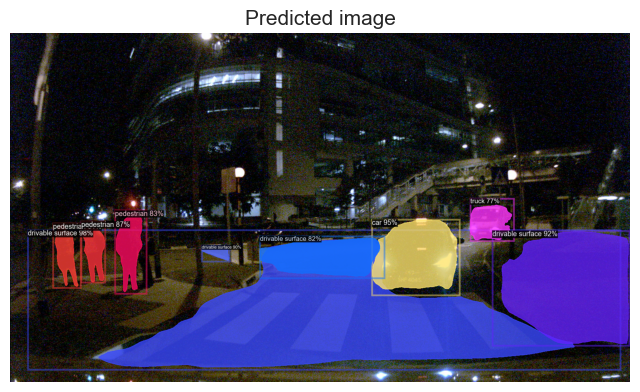

In [34]:
get_predicted_img(val_img,'n015-2018-07-12-19-48-48+0800__CAM_BACK__1531396587687525.jpg')

The model does a good job in detecting the object in the night too.

--- 

## Conclusion

**The model that choosen in this project is Mask RCNN FPN model trained with 4 backbone layers (IOU Threshold 0.75, Predictive threshold 0.7). The model has the best performance in detecting the large objects. The model also has the best performance in detecting the object in the raining weather and night.**

However, there are some important key points that need to be considered before using the model in the real world.
1. The model does not do a good job in distinguishing the pedestrian and construction worker classes.
2. The model also failed to detect the object that is too small that even human eye cannot see it.
3. The mAP of the model is not very high which might not meeting the indurstry requirement.

Therefore, the model can be further improved by:
1. Use more data to train the model. The model can be trained with more epochs to achieve better performance.
2. Train the model with more epochs to achieve better performance.
3. Increase the target classess to build a complete object detection model.
4. Collect and annotate the data for the minority class like construction worker class.

All the improvmement can be done in the future work with enough project resources. 

---